In [ ]:
%pip install nfl_data_py
%pip install fuzzywuzzy
%pip install python-Levenshtein
%pip install networkx
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [164]:
import nfl_data_py as nfl

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
from wordcloud import WordCloud

from fuzzywuzzy import process

In [128]:
# Load play-by-play data for 2024 season
df = nfl.import_pbp_data([2024])
roster_data = nfl.import_seasonal_rosters([2024])
# Show first 5 rows
print(df.head())
print(roster_data.head())

2024 done.
Downcasting floats.
   play_id          game_id old_game_id home_team away_team season_type  week  \
0      1.0  2024_01_ARI_BUF  2024090801       BUF       ARI         REG     1   
1     40.0  2024_01_ARI_BUF  2024090801       BUF       ARI         REG     1   
2     61.0  2024_01_ARI_BUF  2024090801       BUF       ARI         REG     1   
3     83.0  2024_01_ARI_BUF  2024090801       BUF       ARI         REG     1   
4    108.0  2024_01_ARI_BUF  2024090801       BUF       ARI         REG     1   

  posteam posteam_type defteam  ... out_of_bounds  home_opening_kickoff  \
0    None         None    None  ...           0.0                   0.0   
1     ARI         away     BUF  ...           0.0                   0.0   
2     ARI         away     BUF  ...           0.0                   0.0   
3     ARI         away     BUF  ...           0.0                   0.0   
4     ARI         away     BUF  ...           0.0                   0.0   

     qb_epa  xyac_epa  xyac_mea

In [71]:

pbp_column_list = df.columns.tolist()
print(pbp_column_list)

roster_column_list = roster_data.columns.tolist()
print(roster_column_list)

['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_score_post', 'defteam_score_post', 'score_differential

# Cleaning the Data

We only take the data where the first down is successful, i.e. where the first_down columns equals 1.

In [16]:
#now we take only data where first down is successful, success first down is 1
#other options are n/a or 0 we don't need either of these for analysis

# Filter for plays where a first down was achieved
first_down_plays = df[df['first_down'] == 1]

total_plays = len(df)

# Total number of first downs
total_first_downs = len(first_down_plays)

print("Total plays:", total_plays)
print("Total first downs:", int(total_first_downs))

Total plays: 49492
Total first downs: 11148


# Visualizing where the most first down conversions occur and fail

We will now visualize where first downs occur on the field with a heat map. We will sort plays into bins representing a 5 yard section of the field. Bins with a darker hue indicate more first down conversions occurring in that section of the field.

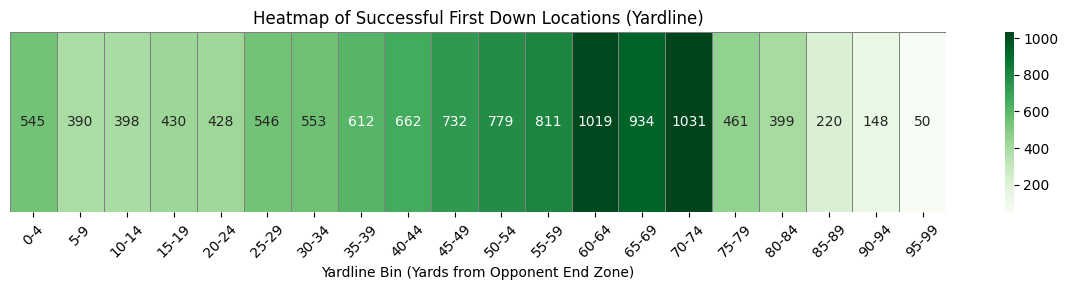

In [21]:
# Extract the yardline_100 and side_of_field (if exists) or just yardline_100
# yardline_100 is yards from opponent's end zone (0 to 100)
# For a heatmap, bin the yardline_100 into segments (for us here every 5 yards)

first_down_plays = first_down_plays.copy()

# Create bins for yardline_100, e.g., every 5 yards
first_down_plays['yard_bin'] = pd.cut(first_down_plays['yardline_100'], bins=range(0, 105, 5), right=False)

# Count first downs per bin
yard_counts = first_down_plays.groupby('yard_bin').size().reset_index(name='count')

# Create a simple heatmap-like bar plot since data is 1D (along the field length)
plt.figure(figsize=(12, 3))
sns.heatmap([yard_counts['count']], cmap='Greens', cbar=True, linewidths=0.5, linecolor='gray', annot=True, fmt='d')

plt.title('Heatmap of Successful First Down Locations (Yardline)')
plt.yticks([], [])  # Hide y-axis ticks since it's just one row
plt.xticks(ticks=[i + 0.5 for i in range(len(yard_counts))], labels=[f"{int(interval.left)}-{int(interval.right-1)}" for interval in yard_counts['yard_bin']], rotation=45)
plt.xlabel('Yardline Bin (Yards from Opponent End Zone)')

plt.tight_layout()
plt.show()

It looks like the most first down conversions happen at the 60-74 yardlines. This makes sense given the 2024 NFL touchback rules and how kickoffs are currently played. 

During kickoff (i.e. when the ball changes possession) if the ball is punted in the endzone or out of the field, the ball is immediately placed at the 30 yard line. When the ball is punted and doesn't reach the end zone, the ball is usally returned to the 30-40 yard line before the player returning the ball gets tackled. 

This means that plays are almost guaranteed to happen at that 60-74 yard section of the field which means more first down conversions are bound to happen. Because of this, it's not entirely honest to say these are the most "money-efficient" zones in achieving first downs.

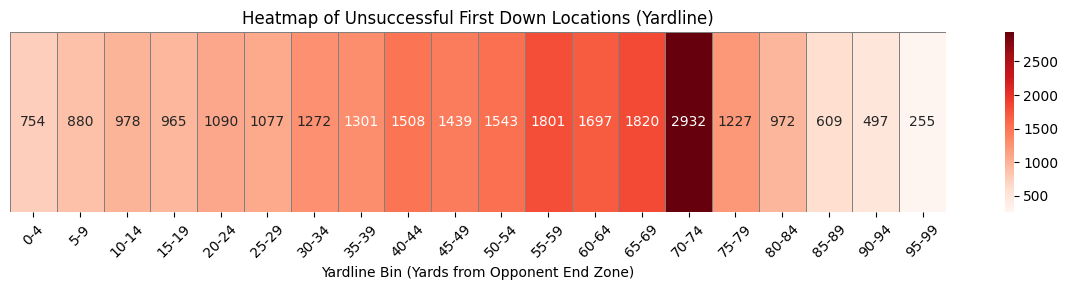

In [34]:
pass_run_plays = df[df['play_type'].isin(['pass', 'run'])]

failed_first_down_plays = pass_run_plays[pass_run_plays['first_down'] != 1].copy()

# Create bins for yardline_100, e.g., every 5 yards
failed_first_down_plays['yard_bin'] = pd.cut(failed_first_down_plays['yardline_100'], bins=range(0, 105, 5), right=False)

# Count first downs per bin
failed_yard_counts = failed_first_down_plays.groupby('yard_bin').size().reset_index(name='count')

plt.figure(figsize=(12, 3))
sns.heatmap([failed_yard_counts['count']], cmap='Reds', cbar=True, linewidths=0.5, linecolor='gray', annot=True, fmt='d')

plt.title('Heatmap of Unsuccessful First Down Locations (Yardline)')
plt.yticks([], [])  # Hide y-axis ticks since it's just one row
plt.xticks(ticks=[i + 0.5 for i in range(len(failed_yard_counts))], labels=[f"{int(interval.left)}-{int(interval.right-1)}" for interval in failed_yard_counts['yard_bin']], rotation=45)
plt.xlabel('Yardline Bin (Yards from Opponent End Zone)')

plt.tight_layout()
plt.show()

The heatmap of unsuccessful first down conversions indicate a similar trend. Most first down conversion failures happen at around the 70-74 yard section as that's where most scoring drives starts. This means the ball is most often played in that section of the field so naturally that's where the most first down conversion failures happen.

# First Downs by Team

Now we will examine first down conversions by team. We will again,  To do this we will use the "posteam" column that indicates the team that had possession of the ball (i.e. the team on offense).

In [169]:
# Group by team on offense and count first downs
first_downs_by_team = first_down_plays.groupby('posteam')['first_down'].count()

# Sort and display
print(first_downs_by_team.sort_values(ascending=False).head())


posteam
WAS    447
PHI    440
BAL    438
DET    433
BUF    423
Name: first_down, dtype: int64


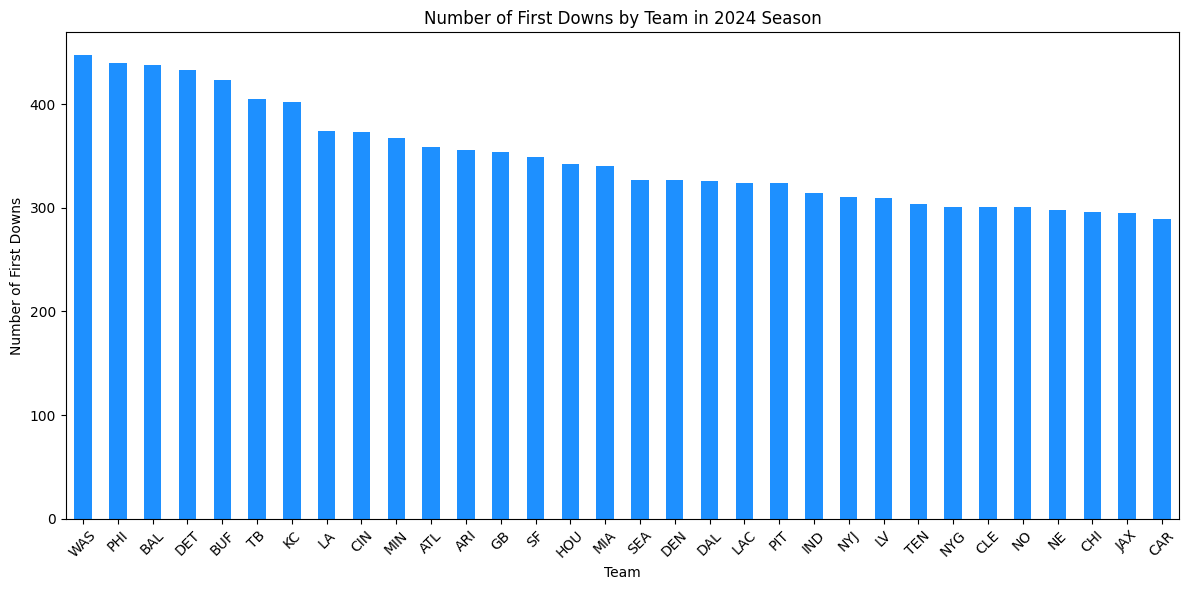

In [170]:
first_downs_by_team = first_downs_by_team.sort_values(ascending=False)

# Plot
plt.figure(figsize=(12,6))
first_downs_by_team.plot(kind='bar', color='dodgerblue')

plt.title('Number of First Downs by Team in 2024 Season')
plt.xlabel('Team')
plt.ylabel('Number of First Downs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Player-by-Player Efficiency

We'll now see which players were in most first downs plays in 2024. There's no single column with all 22 players in a formation so we'll include all players.

In [171]:
def get_player_info(player_id, column_name):
    """
    Get the player's name from the roster data using player_id.
    If player_id is not found, return 'Unknown Player'.
    """
    player_row = roster_data[roster_data['player_id'] == player_id]
    if not player_row.empty:
        return player_row[column_name].values[0]
    else:
        return 'Unknown Player'
    


# Define possible player columns for first down plays
possible_player_cols = [
    'passer_player_id',
    'rusher_player_id',
    'receiver_player_id'
]

# Make sure we only use existing columns
existing_player_cols = [col for col in possible_player_cols if col in first_down_plays.columns]

# Collect all player info using the id columns
player_info = []

for id_col in existing_player_cols:
    temp_df = first_down_plays[[id_col, 'posteam']].dropna()
    temp_df["player_name"] = temp_df[id_col].apply(lambda x: get_player_info(x, 'player_name'))
    temp_df["player_position"] = temp_df[id_col].apply(lambda x: get_player_info(x, 'position'))
    
    player_info.append(temp_df)

# Combine all information DataFrames into one DataFrame
all_player_info_df = pd.concat(player_info)

# Filter columns to only relevant columns: player name and team
all_player_teams = all_player_info_df[['player_name', 'posteam']]
all_player_teams.columns = ['Player', 'Team']

# # Count occurrences of each player-team pair
player_team_counts = all_player_teams.value_counts().reset_index()
player_team_counts.columns = ['Player', 'Team', 'First_Down_Count',]

# # Sort and show top results
player_team_counts = player_team_counts.sort_values(by='First_Down_Count', ascending=False).reset_index(drop=True)

# # Show top 20
print(player_team_counts.head(20))

              Player Team  First_Down_Count
0     Jayden Daniels  WAS               281
1    Patrick Mahomes   KC               278
2      Lamar Jackson  BAL               277
3         Joe Burrow  CIN               270
4         Josh Allen  BUF               268
5         Jared Goff  DET               266
6     Baker Mayfield   TB               263
7        Jalen Hurts  PHI               257
8        Sam Darnold  MIN               248
9        C.J. Stroud  HOU               232
10        Geno Smith  SEA               228
11            Bo Nix  DEN               225
12      Kyler Murray  ARI               223
13       Brock Purdy   SF               214
14  Matthew Stafford   LA               213
15    Justin Herbert  LAC               208
16     Aaron Rodgers  NYJ               201
17    Caleb Williams  CHI               200
18       Jordan Love   GB               175
19    Tua Tagovailoa  MIA               169


We can visualize first down participations with a word cloud. Bigger names having contributed to more first downs

                Player Team  First_Down_Count
0       Jayden Daniels  WAS               281
1      Patrick Mahomes   KC               278
2        Lamar Jackson  BAL               277
3           Joe Burrow  CIN               270
4           Josh Allen  BUF               268
..                 ...  ...               ...
539           Jack Fox  DET                 1
540      Mike Caliendo   KC                 1
541      Dallin Holker   NO                 1
542  Tyreik McAllister   LV                 1
543       Ashtyn Davis  NYJ                 1

[544 rows x 3 columns]


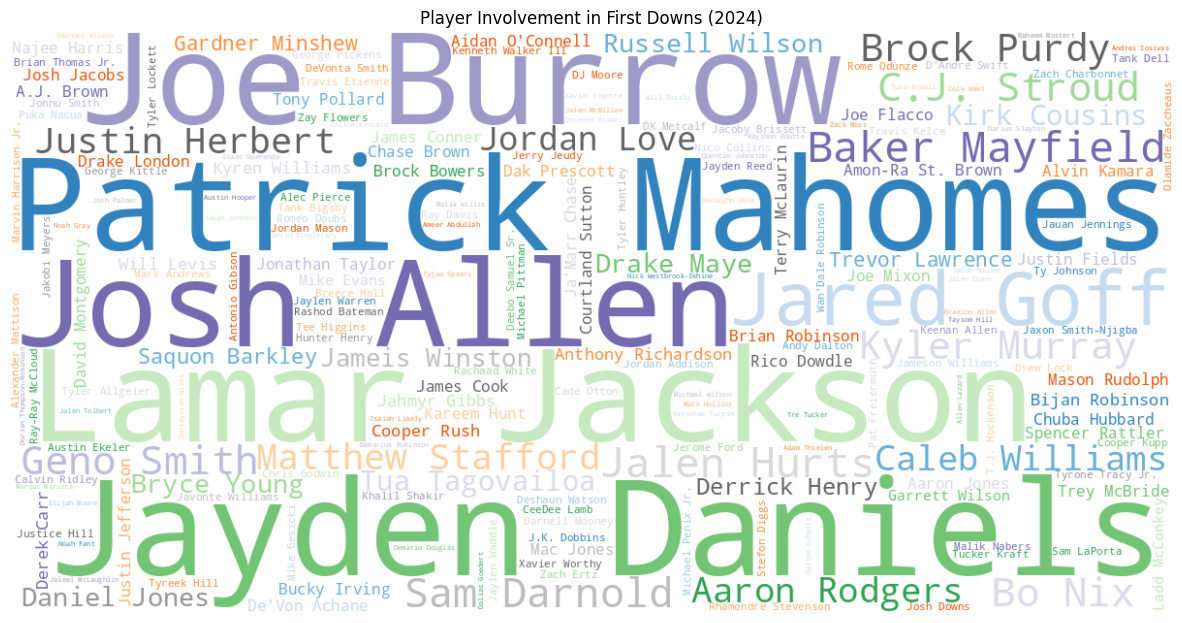

In [172]:
# Create the word cloud
print(player_team_counts)
player_counts = player_team_counts.set_index('Player')['First_Down_Count'].to_dict()

wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='tab20c').generate_from_frequencies(player_counts)

# Plot the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Player Involvement in First Downs (2024)')
plt.show()

Now that we know all the players we'll see which ones are most efficient cost-wise. We'll combine the salary csv with the player first down count dataframe. Due to the size of the csv and variance within names, we will use fuzzy matching to join the csv with the dataframe.

In [ ]:
# Fuzzy match helper function
def get_best_match(player, choices, threshold=85):
    match, score = process.extractOne(player, choices)
    return match if score >= threshold else None

In [ ]:
# Load data
df_salary = pd.read_csv('overthecap/overthecap-earnings.csv')
df_salary = df_salary[df_salary['year'] == 2024]  # Filter only 2024

# Strip whitespace from player names
df_salary['player_name'] = df_salary['player_name'].str.strip()
player_team_counts['Player'] = player_team_counts['Player'].str.strip()

# Get salary names
salary_names = df_salary['player_name'].unique().tolist()

# Fuzzy match each player
player_team_counts['matched_salary_name'] = player_team_counts['Player'].apply(
    lambda x: get_best_match(x, salary_names)
)

# Merge on matched player names
merged_df = pd.merge(
    player_team_counts,
    df_salary,
    left_on='matched_salary_name',
    right_on='player_name',
    how='left'
)

# Drop players with no salary info
merged_df = merged_df.dropna(subset=['base_salary'])



With each player matched to their base salary, we can then sort them by their individual salary per first down they participated in.

In [195]:
# Convert base_salary to numeric, handling any potential issues with conversion
merged_df['base_salary'] = merged_df['base_salary'].astype(float)

print(merged_df.head())

# Compute salary per first down
merged_df['salary_per_first_down'] = merged_df['base_salary'] / merged_df['First_Down_Count']

# Clean final output
final_df = merged_df[['Player', 'team', 'First_Down_Count', 'base_salary', 'salary_per_first_down']]

# Remove duplicates: if player matched multiple teams, keep the one with most first downs
final_df = final_df.sort_values(['Player', 'First_Down_Count'], ascending=[True, False]).drop_duplicates('Player')

# Sort by salary efficiency
final_df = final_df.sort_values('salary_per_first_down', ascending=True)

# Format salary columns
final_df['base_salary'] = final_df['base_salary'].apply(lambda x: f"${x:,.2f}")
final_df['salary_per_first_down'] = final_df['salary_per_first_down'].apply(lambda x: f"${x:,.2f}")

# Display
print(final_df.head(20).to_string(index=False))

            Player Team  First_Down_Count matched_salary_name  \
0   Jayden Daniels  WAS               281      Jayden Daniels   
1  Patrick Mahomes   KC               278     Patrick Mahomes   
2    Lamar Jackson  BAL               277       Lamar Jackson   
3    Lamar Jackson  BAL               277       Lamar Jackson   
4       Joe Burrow  CIN               270          Joe Burrow   

       player_name    year        team  base_salary  prorated_bonus  \
0   Jayden Daniels  2024.0  Commanders     795000.0       6068027.0   
1  Patrick Mahomes  2024.0      Chiefs    9850000.0      18258269.0   
2    Lamar Jackson  2024.0      Ravens   14250000.0      14650000.0   
3    Lamar Jackson  2024.0     Falcons     225000.0             NaN   
4       Joe Burrow  2024.0     Bengals   10714982.0       7836130.0   

   roster_bonus  workout_bonus  Unnamed: 7  guaranteed_salary   capnumber  \
0           0.0            NaN         NaN           795000.0   6863027.0   
1     7900000.0      1000000

As it turns out, this ended up being a list mainly of quarterbacks. Which makes sense because quarterbacks participate in every offensive play. So let's focus our analysis on quarterback receiver pairs.

Below is a network visualization of every quarterback connected to every receiver they have made a pass too

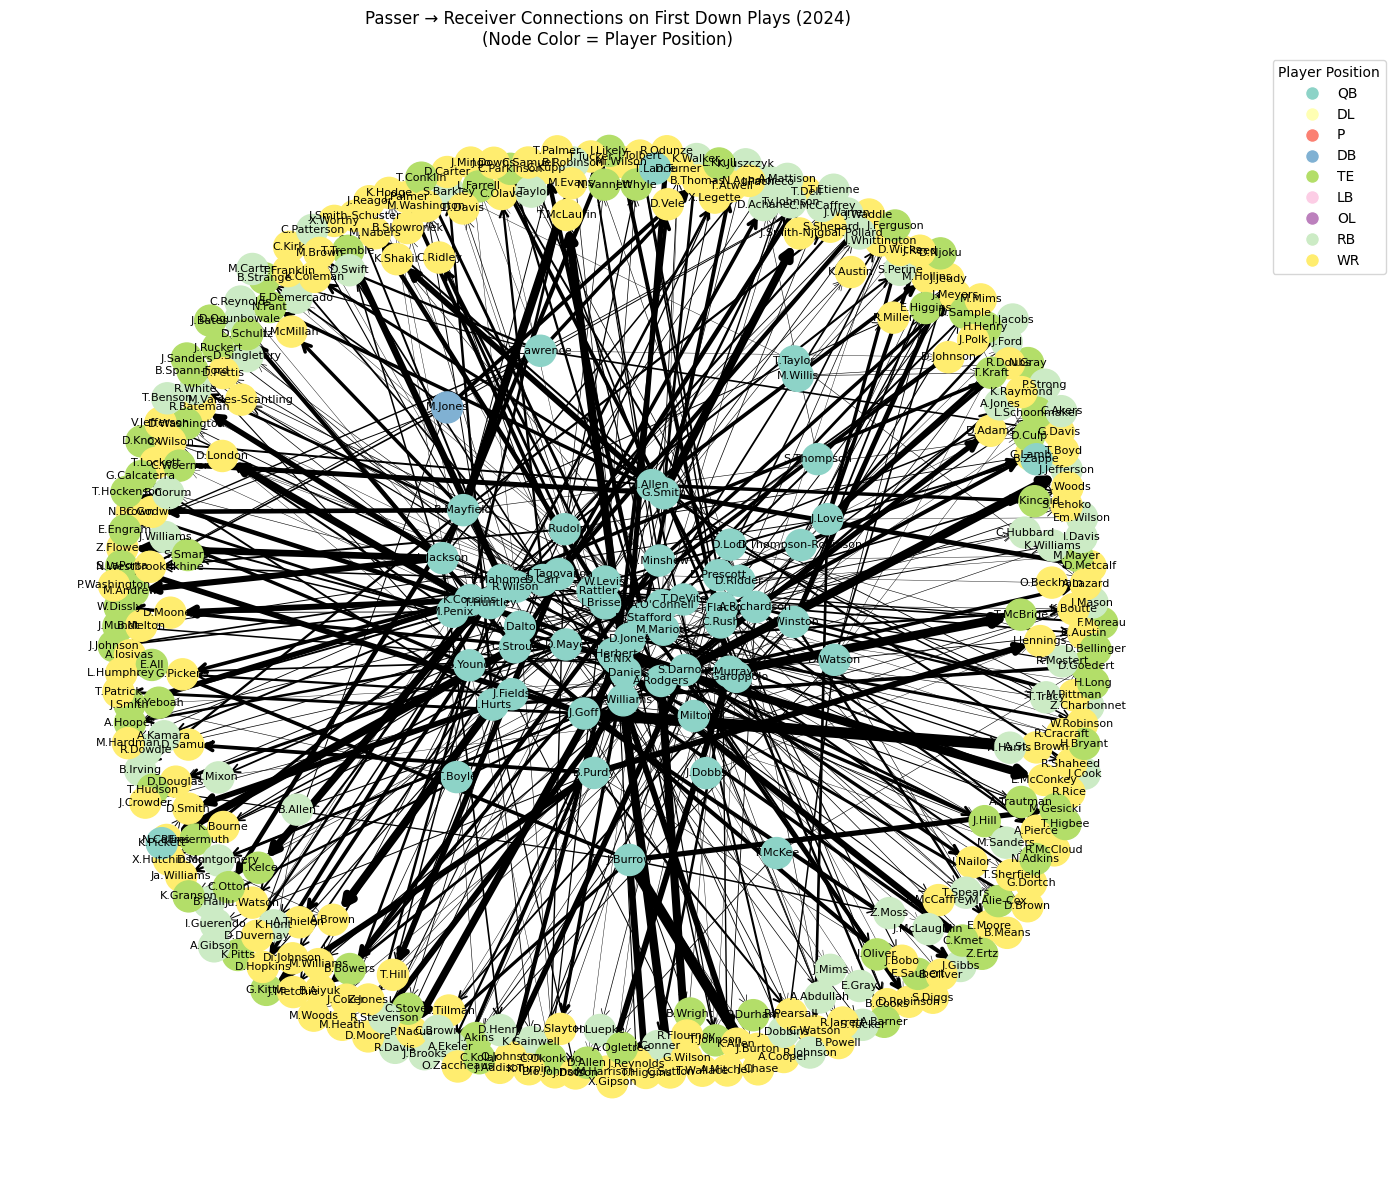

In [175]:
# Filter for plays resulting in a first down and where both passer and receiver are known
fd_pass_plays = df[
    (df['first_down'] == 1) &
    (df['passer_player_name'].notna()) &
    (df['receiver_player_name'].notna())
].copy()

fd_pass_plays["passer_position"] = fd_pass_plays['passer_player_id'].apply(lambda x: get_player_info(x, 'position'))
fd_pass_plays["receiver_position"] = fd_pass_plays['receiver_player_id'].apply(lambda x: get_player_info(x, 'position'))

# Create edge list: (passer, receiver)
edges = list(zip(fd_pass_plays['passer_player_name'], fd_pass_plays['receiver_player_name']))

# Create a directed graph
G = nx.DiGraph()

# Add edges with weights (count how many times each passer → receiver pair occurs)
for edge in edges:
    if G.has_edge(*edge):
        G[edge[0]][edge[1]]['weight'] += 1
    else:
        G.add_edge(edge[0], edge[1], weight=1)

# Optionally, filter edges to show only those with weight > threshold (e.g., 2)
edges_to_draw = [(u, v) for u, v, w in G.edges(data='weight') if w > 2]

H = G.edge_subgraph(edges_to_draw).copy()

# Create a mapping of player names to positions
player_positions = {}

# Add passer positions
for _, row in fd_pass_plays[['passer_player_name', 'passer_position']].drop_duplicates().iterrows():
    player_positions[row['passer_player_name']] = row['passer_position']

# Add receiver positions
for _, row in fd_pass_plays[['receiver_player_name', 'receiver_position']].drop_duplicates().iterrows():
    player_positions[row['receiver_player_name']] = row['receiver_position']

# Get unique positions and create color mapping
unique_positions = list(set(player_positions.values()))
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_positions)))
position_color_map = dict(zip(unique_positions, colors))

# Map colors to nodes in the graph
node_colors = []
for node in H.nodes():
    if node in player_positions:
        node_colors.append(position_color_map[player_positions[node]])
    else:
        node_colors.append('gray')  # Default color for unknown positions

# Plotting
plt.figure(figsize=(14,12))

# Position nodes using spring layout (forces)
pos = nx.spring_layout(H, k=0.5, iterations=50)

# Draw nodes with position-based colors
nx.draw_networkx_nodes(H, pos, node_size=500, node_color=node_colors)

# Draw edges with widths proportional to weight (made thinner)
weights = [H[u][v]['weight'] for u,v in H.edges()]
nx.draw_networkx_edges(H, pos, width=[w*0.1 for w in weights], arrowstyle='->', arrowsize=15)

# Draw labels
nx.draw_networkx_labels(H, pos, font_size=8)

# Create legend for positions
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=position_color_map[pos], 
                             markersize=10, label=pos) 
                  for pos in unique_positions]
plt.legend(handles=legend_elements, title='Player Position', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Passer → Receiver Connections on First Down Plays (2024)\n(Node Color = Player Position)")
plt.axis('off')
plt.tight_layout()
plt.show()


While the visualization looks very chaotic, it shows that quarterbacks, largely clustered in the center pass to a variety of people and positions, who are visually represented by a ring around the quarterbacks.

While there are a lot of players involved we may actually want initially to consider the most relevant players involved in passing plays

In [176]:
# Filter for plays with a first down via pass, and valid passer + receiver names
first_down_passes = df[
    (df['first_down_pass'] == 1) & 
    df['passer_player_name'].notna() & 
    df['receiver_player_name'].notna() & 
    df['posteam'].notna()
].copy()

# Get full names for passer and receiver
first_down_passes['passer_player_name'] = first_down_passes['passer_player_id'].apply(lambda x: get_player_info(x, 'player_name'))
first_down_passes['receiver_player_name'] = first_down_passes['receiver_player_id'].apply(lambda x: get_player_info(x, 'player_name'))

# Group by passer, receiver, and offensive team (posteam), count occurrences
pair_counts = (
    first_down_passes
    .groupby(['passer_player_name', 'receiver_player_name', 'posteam'])
    .size()
    .reset_index(name='First_Down_Count')
    .sort_values(by='First_Down_Count', ascending=False)
)

print(pair_counts.head(20))

    passer_player_name receiver_player_name posteam  First_Down_Count
304         Jared Goff    Amon-Ra St. Brown     DET                81
344         Joe Burrow        Ja'Marr Chase     CIN                75
569        Sam Darnold     Justin Jefferson     MIN                64
451       Kyler Murray         Trey McBride     ARI                63
67              Bo Nix     Courtland Sutton     DEN                61
57      Baker Mayfield           Mike Evans      TB                60
421     Justin Herbert        Ladd McConkey     LAC                59
118        C.J. Stroud         Nico Collins     HOU                58
5        Aaron Rodgers       Garrett Wilson     NYJ                58
280        Jalen Hurts           A.J. Brown     PHI                58
329     Jayden Daniels       Terry McLaurin     WAS                57
253         Geno Smith   Jaxon Smith-Njigba     SEA                56
544    Patrick Mahomes         Travis Kelce      KC                54
511   Matthew Staffo

In [181]:
grouped = (
    first_down_passes
    .groupby(['posteam', 'passer_player_name', 'receiver_player_name'])
    .size()
    .reset_index(name='First_Down_Count')
)

# Now, for example, get top 5 pairs per team
top_pairs_per_team = grouped.groupby('posteam').apply(
    lambda x: x.sort_values('First_Down_Count', ascending=False).head(5)
).reset_index(drop=True)

print(top_pairs_per_team)

    posteam passer_player_name receiver_player_name  First_Down_Count
0       ARI       Kyler Murray         Trey McBride                63
1       ARI       Kyler Murray  Marvin Harrison Jr.                43
2       ARI       Kyler Murray       Michael Wilson                27
3       ARI       Kyler Murray         James Conner                17
4       ARI       Kyler Murray          Greg Dortch                16
..      ...                ...                  ...               ...
155     WAS     Jayden Daniels       Terry McLaurin                57
156     WAS     Jayden Daniels            Zach Ertz                46
157     WAS     Jayden Daniels    Olamide Zaccheaus                26
158     WAS     Jayden Daniels          Dyami Brown                21
159     WAS     Jayden Daniels           Noah Brown                20

[160 rows x 4 columns]


In [182]:
# For each team, get the top pair by First_Down_Count
top_pair_per_team = grouped.loc[grouped.groupby('posteam')['First_Down_Count'].idxmax()]

print(top_pair_per_team)

    posteam passer_player_name receiver_player_name  First_Down_Count
10      ARI       Kyler Murray         Trey McBride                63
15      ATL       Kirk Cousins         Drake London                52
41      BAL      Lamar Jackson          Zay Flowers                48
48      BUF         Josh Allen        Khalil Shakir                42
70      CAR        Bryce Young         Adam Thielen                26
87      CHI     Caleb Williams             DJ Moore                43
100     CIN         Joe Burrow        Ja'Marr Chase                75
137     CLE     Jameis Winston          Jerry Jeudy                36
143     DAL        Cooper Rush          CeeDee Lamb                27
175     DEN             Bo Nix     Courtland Sutton                61
196     DET         Jared Goff    Amon-Ra St. Brown                81
220      GB        Jordan Love          Romeo Doubs                30
236     HOU        C.J. Stroud         Nico Collins                58
265     IND         

In [ ]:
# Fuzzy match passer and receiver names to salary data
pair_salary_df = top_pair_per_team.copy()

pair_salary_df['passer_match'] = pair_salary_df['passer_player_name'].apply(lambda x: get_best_match(x, salary_names))
pair_salary_df['receiver_match'] = pair_salary_df['receiver_player_name'].apply(lambda x: get_best_match(x, salary_names))

# Merge salaries for passer
pair_salary_df = pair_salary_df.merge(
    df_salary[['player_name', 'base_salary']],
    left_on='passer_match',
    right_on='player_name',
    how='left'
).rename(columns={'base_salary': 'passer_salary'}).drop(columns=['player_name'])

# Merge salaries for receiver
pair_salary_df = pair_salary_df.merge(
    df_salary[['player_name', 'base_salary']],
    left_on='receiver_match',
    right_on='player_name',
    how='left'
).rename(columns={'base_salary': 'receiver_salary'}).drop(columns=['player_name'])

# Fill missing salaries with 0 (or you can drop those rows if you prefer)
pair_salary_df['passer_salary'] = pair_salary_df['passer_salary'].fillna(0)
pair_salary_df['receiver_salary'] = pair_salary_df['receiver_salary'].fillna(0)

# Calculate total salary and salary per first down
pair_salary_df['total_salary'] = pair_salary_df['passer_salary'] + pair_salary_df['receiver_salary']
pair_salary_df['salary_per_first_down'] = pair_salary_df['total_salary'] / pair_salary_df['First_Down_Count']

pair_salary_df = pair_salary_df.sort_values(by='salary_per_first_down', ascending=True)

# Format dollar amounts
pair_salary_df['passer_salary'] = pair_salary_df['passer_salary'].apply(lambda x: f"${x:,.2f}")
pair_salary_df['receiver_salary'] = pair_salary_df['receiver_salary'].apply(lambda x: f"${x:,.2f}")
pair_salary_df['total_salary'] = pair_salary_df['total_salary'].apply(lambda x: f"${x:,.2f}")
pair_salary_df['salary_per_first_down'] = pair_salary_df['salary_per_first_down'].apply(lambda x: f"${x:,.2f}")

# Show relevant columns
display_df = pair_salary_df[['posteam', 'passer_player_name', 'receiver_player_name', 'First_Down_Count', 'passer_salary', 'receiver_salary', 'total_salary', 'salary_per_first_down']]
print(display_df.head(20).to_string(index=False))

posteam passer_player_name receiver_player_name  First_Down_Count passer_salary receiver_salary  total_salary salary_per_first_down
    BAL      Lamar Jackson          Zay Flowers                48   $225,000.00     $978,020.00 $1,203,020.00            $25,062.92
    DEN             Bo Nix     Courtland Sutton                61   $795,000.00   $1,125,000.00 $1,920,000.00            $31,475.41
    PHI        Jalen Hurts           A.J. Brown                58 $1,125,000.00   $1,125,000.00 $2,250,000.00            $38,793.10
     TB     Baker Mayfield           Mike Evans                60 $1,125,000.00   $1,210,000.00 $2,335,000.00            $38,916.67
    HOU        C.J. Stroud         Nico Collins                58   $915,000.00   $1,616,000.00 $2,531,000.00            $43,637.93
    DET         Jared Goff    Amon-Ra St. Brown                81 $2,611,832.00   $1,366,000.00 $3,977,832.00            $49,109.04
     SF        Brock Purdy        George Kittle                44   $985,000

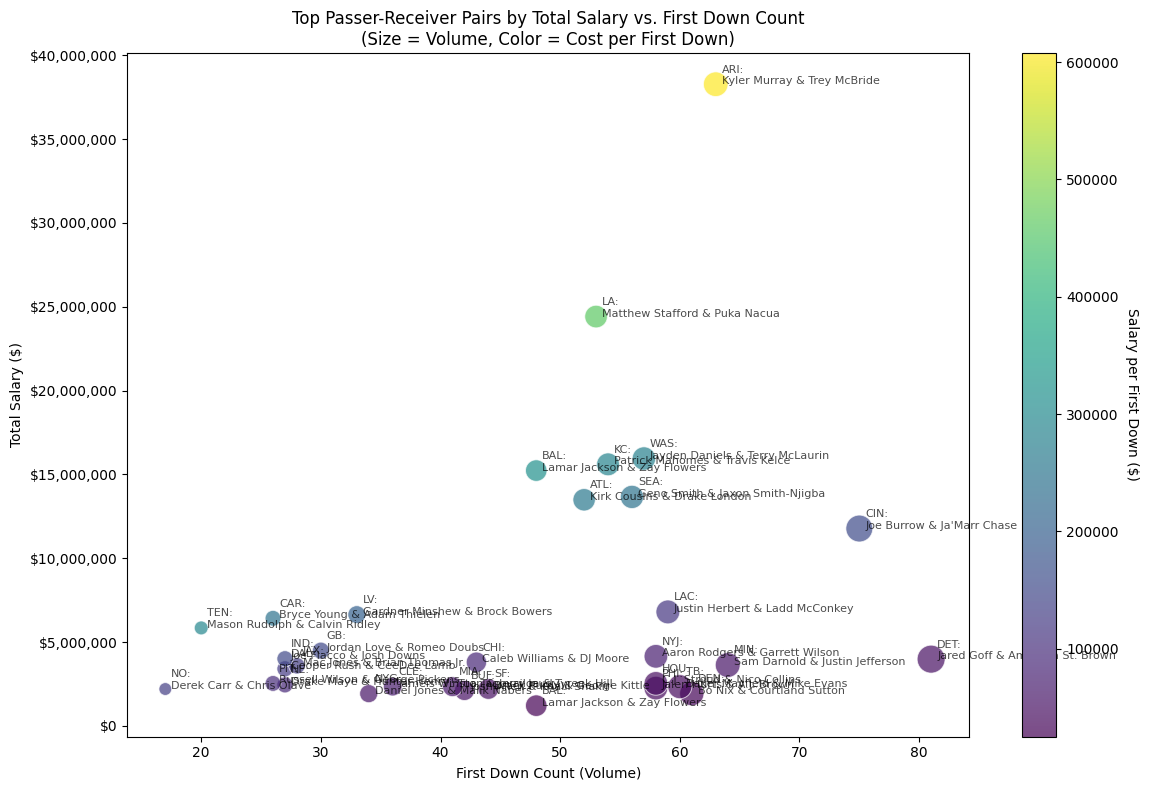

In [191]:
# Make sure salary_per_first_down is numeric (remove $ and commas if formatted)
df_plot = pair_salary_df.copy()
df_plot['salary_per_first_down_num'] = df_plot['salary_per_first_down'].replace('[\$,]', '', regex=True).astype(float)
df_plot['total_salary'] = df_plot['total_salary'].replace('[\$,]', '', regex=True).astype(float)

plt.figure(figsize=(12, 8))

# Scatter plot
scatter = plt.scatter(
    x=df_plot['First_Down_Count'],           # X-axis: volume
    y=df_plot['total_salary'],                # Y-axis: total salary
    c=df_plot['salary_per_first_down_num'],  # Color: cost efficiency
    s=df_plot['First_Down_Count'] * 5,       # Size proportional to volume (optional scaling)
    cmap='viridis',
    alpha=0.7,
    edgecolors='w',
    linewidth=0.7
)

# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Salary per First Down ($)', rotation=270, labelpad=15)

# Labels & title
plt.xlabel('First Down Count (Volume)')
plt.ylabel('Total Salary ($)')
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.title('Top Passer-Receiver Pairs by Total Salary vs. First Down Count\n(Size = Volume, Color = Cost per First Down)')

# Annotate with team and pair names for better context (optional)
for _, row in df_plot.iterrows():
    plt.text(
        row['First_Down_Count'] + 0.5, 
        row['total_salary'], 
        f"{row['posteam']}:\n{row['passer_player_name']} & {row['receiver_player_name']}",
        fontsize=8,
        alpha=0.7
    )

plt.tight_layout()
plt.show()